# TP3 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. Obtener una detección del logo en cada imagen sin falsos positivos.
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coco_multi.png` con el mismo template del ítem 1.
3. Generalizar el algoritmo del ítem 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

## Parte 1

1. Obtener una detección del logo en cada imagen sin falsos positivos.


In [163]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import math

In [164]:
# definiciones generales
base_path = './enunciado/images/'
image_files_single = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']

multi_image = 'coca_multi.png'
# template
template_path = './enunciado/template/pattern.png'

# lista de imagenes a procesar 
full_image_paths = [f"{base_path}{image_path}" for image_path in image_files_single]

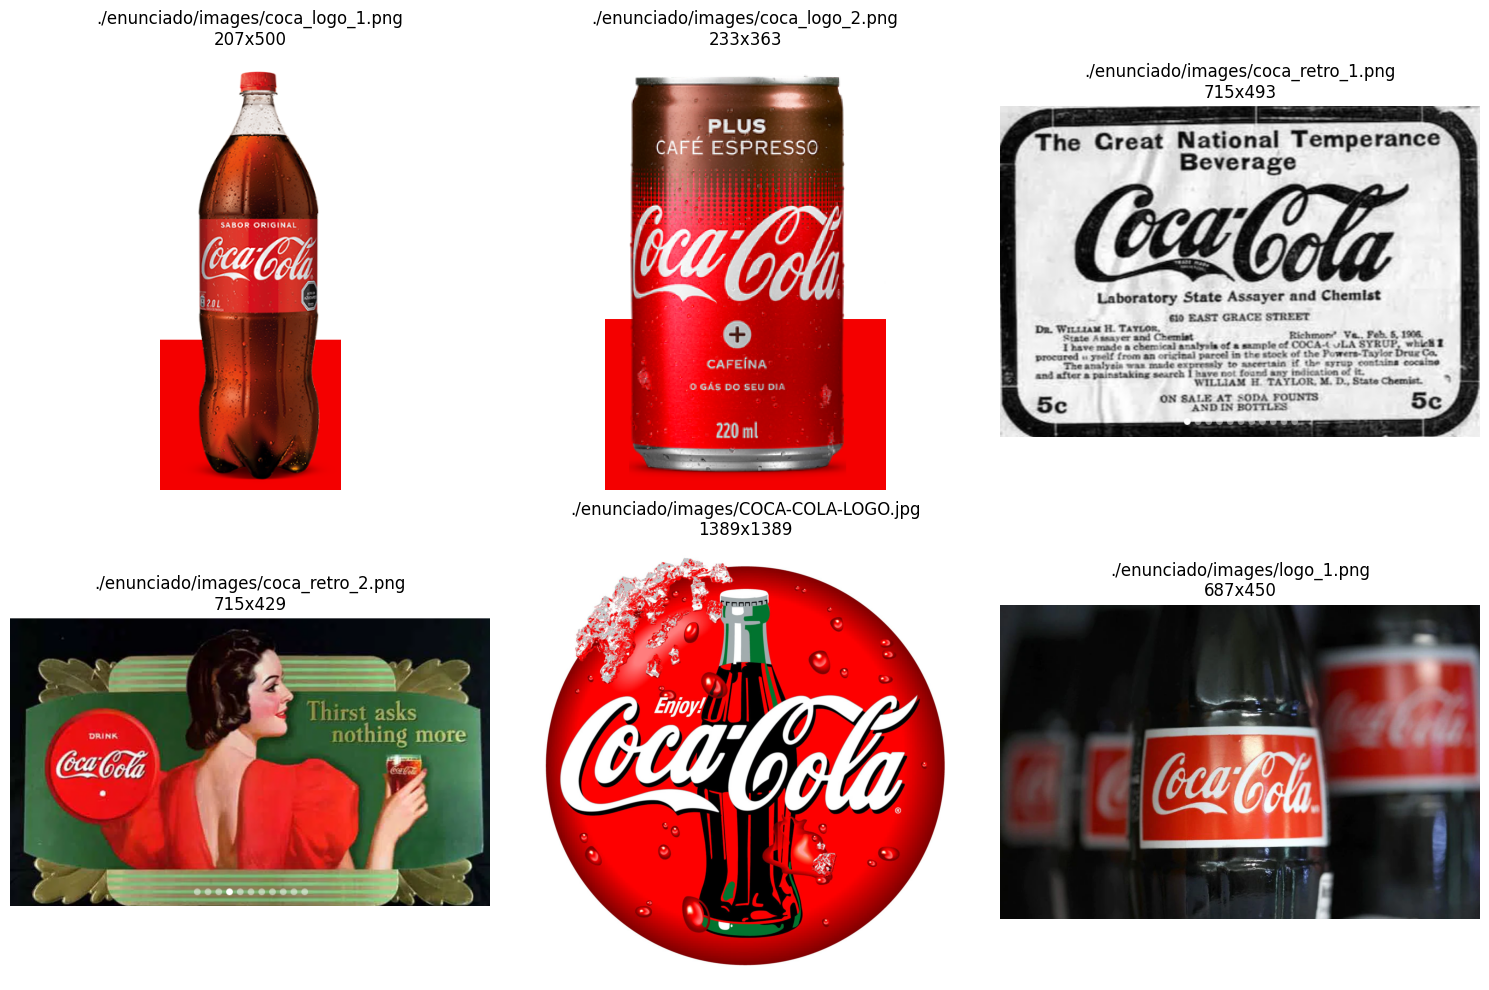

In [165]:
def show_images(image_paths):
    num_images = len(image_paths)
    num_cols = 3
    num_rows = math.ceil(num_images / num_cols)
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, img_path in enumerate(image_paths):
        img = cv.imread(img_path)
        if img is not None and not img.size == 0:
            imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            height, width = img.shape[:2]
            title = f'{img_path}\n{width}x{height}'
            axs[i // num_cols, i % num_cols].imshow(imgRGB)
            axs[i // num_cols, i % num_cols].set_title(title)
            axs[i // num_cols, i % num_cols].axis('off')
        else:
            print(f"Error: {img_path} está vacía o cargada incorrectamente.")
    
    # Ocultar ejes no utilizados
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j // num_cols, j % num_cols])

    plt.tight_layout()
    plt.show()

# Visalizo las imagenes que tengo que procesar
show_images(full_image_paths)


Dimensiones del template: 400x175


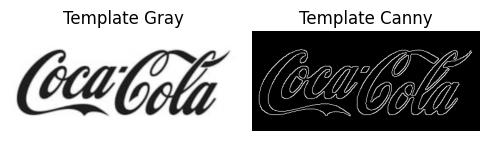

In [169]:
# Cargo el template y lo visualizo
template = cv.imread(template_path)

if template is None:
    raise FileNotFoundError(f"No se pudo cargar el template desde {template_path}")
else:
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    w, h = template_gray.shape[::-1]
    print(f"Dimensiones del template: {w}x{h}")

# Aplicar Canny al template
template = cv.Canny(template_gray, 50, 200)

# Visualizar el template en escala de grises y con Canny uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].imshow(template_gray, cmap='gray')
axs[0].set_title('Template Gray')
axs[0].axis('off')

axs[1].imshow(template, cmap='gray')
axs[1].set_title('Template Canny')
axs[1].axis('off')

plt.tight_layout()
plt.show()



In [168]:
# Visualizo el tamaño de cada imagen y ademas el del template
w_template, h_template = template.shape[::-1]

for i, image in enumerate(full_image_paths):
    img = cv.imread(image)
    if img is not None and not img.size == 0:
        imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        print(f"Tamaño template/imagen {i}: {h_template}-{w_template} / {height}-{width}")
    else:
        print(f"Error: {image} está vacía o cargada incorrectamente.")

Tamaño template/imagen 0: 175-400 / 500-207
Tamaño template/imagen 1: 175-400 / 363-233
Tamaño template/imagen 2: 175-400 / 493-715
Tamaño template/imagen 3: 175-400 / 429-715
Tamaño template/imagen 4: 175-400 / 1389-1389
Tamaño template/imagen 5: 175-400 / 450-687


Veo que tengo varias diferencias de escala entre las imagenes y el template. Sobre todo tengo un tema con una imagen que es muy grande en comparacion al resto

In [176]:
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

In [177]:
# Escalas a probar
scales = [0.35, 3, 2, 1.5, 1, 0.75, 0.5, 0.4, 0.25]

# Función para detectar el logo en las imágenes
def detect_logo_in_images(img_paths, template, methods, scales):
    # Dimensiones del temaplate
    h_template, w_template = template.shape[:2]

    for img_path in img_paths:
        # cargo la imagen
        img = cv.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen desde {img_path}")
            continue

        h_img, w_img = img.shape[:2]
        fig, axs = plt.subplots(1, 6, figsize=(20, 10))
        
        for j, meth in enumerate(methods):
            max_value = []
            max_local = []
            min_value = []
            min_local = []
            used_scales = []
            method = eval(meth)

            for scale in scales:
                # redimensionar la imagen de acuerdo a la escala
                img_rz = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
                w_rz, h_rz = img_rz.shape[1], img_rz.shape[0]
                
                # verifico si el tamaño redimensionado es suficiente para el template
                if h_rz < h_template or w_rz < w_template:
                    continue

                image_gray = cv.cvtColor(img_rz, cv.COLOR_BGR2GRAY)
                img_canny = cv.Canny(image_gray, 100, 200)
                

                res = cv.matchTemplate(img_canny, template, method)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                
                # almaceno los valores y ubicaciones de acuerdo al método
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    min_value.append(min_val)
                    min_local.append(min_loc)
                else:
                    max_value.append(max_val)
                    max_local.append(max_loc)
                used_scales.append(scale)

            # trato de determinar el mejor resultado para el metodo y las listas de valores
            id = np.argmin(min_value) if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else np.argmax(max_value)
            local = min_local[id] if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_local[id]
            scale_used = used_scales[id]
            x, y = np.divide(local, scale_used)
            
            # coordenadas del bounding box
            h_rectangle, w_rectangle = np.divide((h_template, w_template), scale_used)
            bottom_right = (int(x + w_rectangle), int(y + h_rectangle))
            top_left = (int(x), int(y))
            
            # bounding box en la imagen
            img_plot = img.copy()
            cv.rectangle(img_plot, top_left, bottom_right, (255, 0, 0), 5)
            
            axs[j].imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
            axs[j].set_title(meth)
            axs[j].axis('off')

        plt.suptitle(f'Detecciones en {img_path}')
        plt.show()

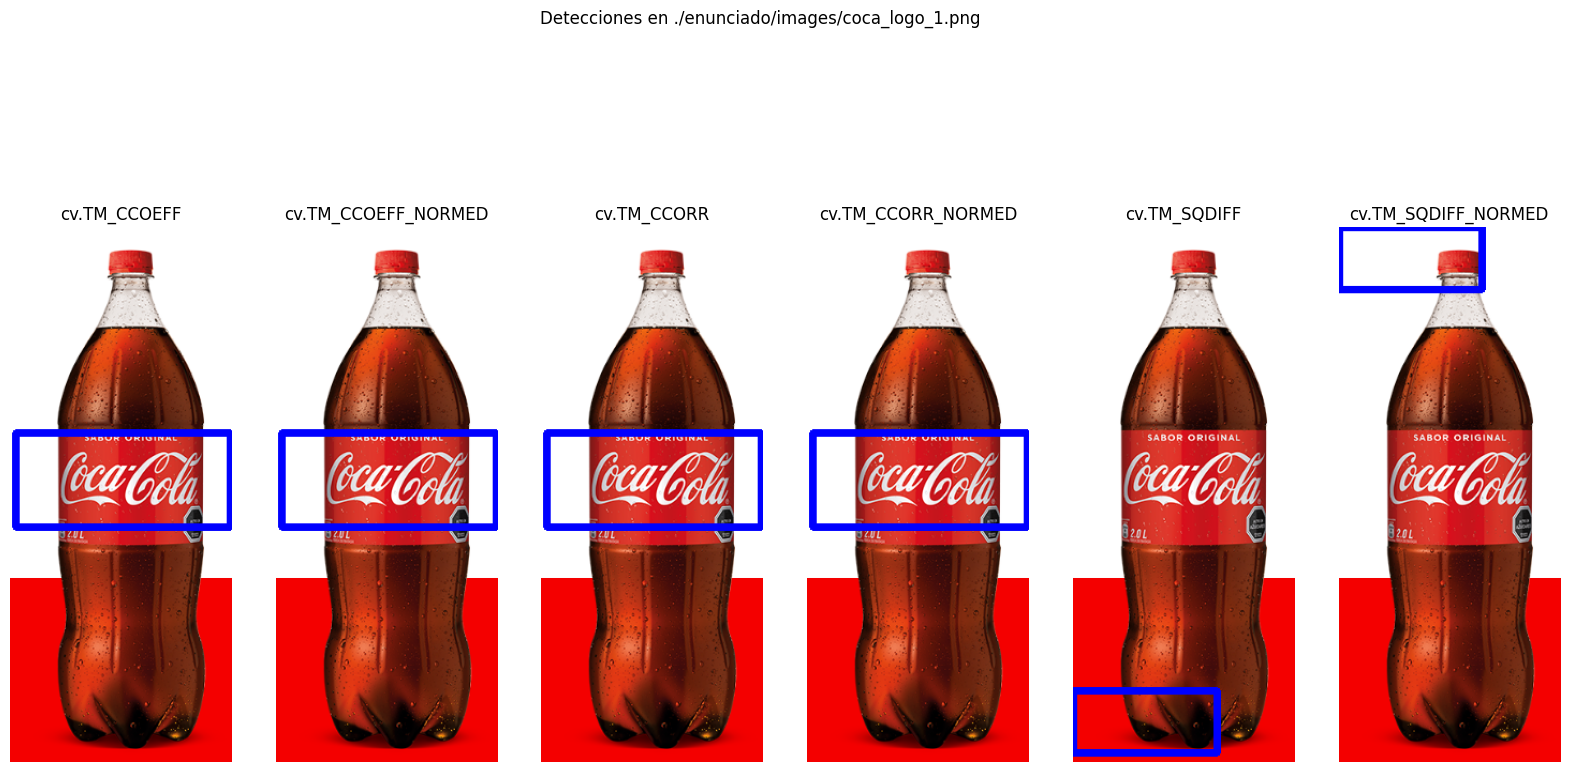

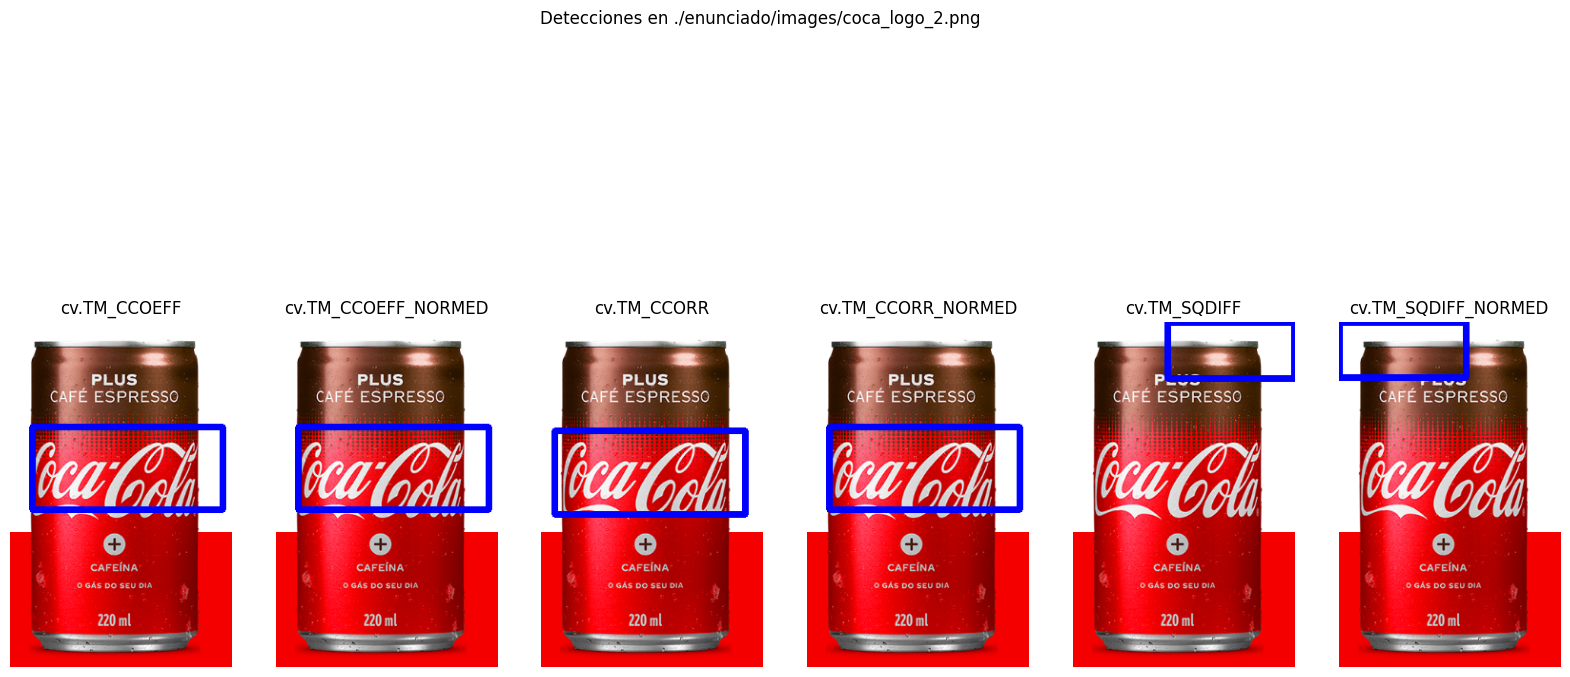

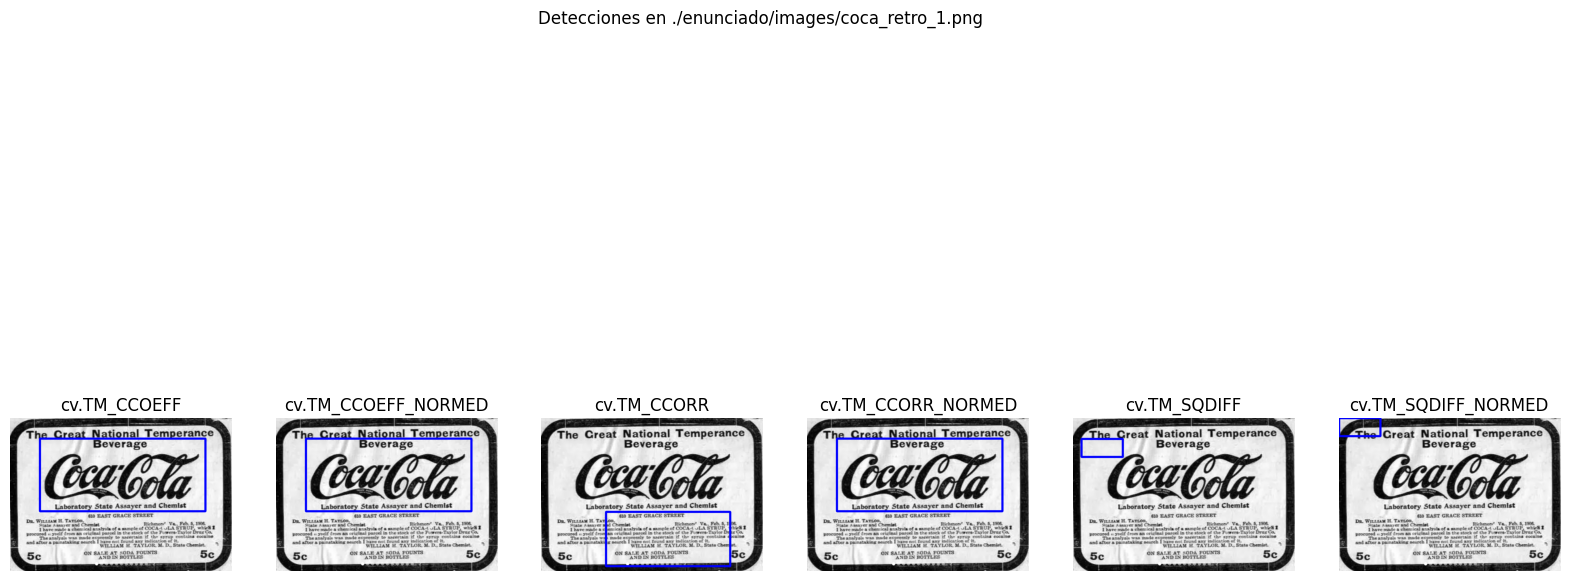

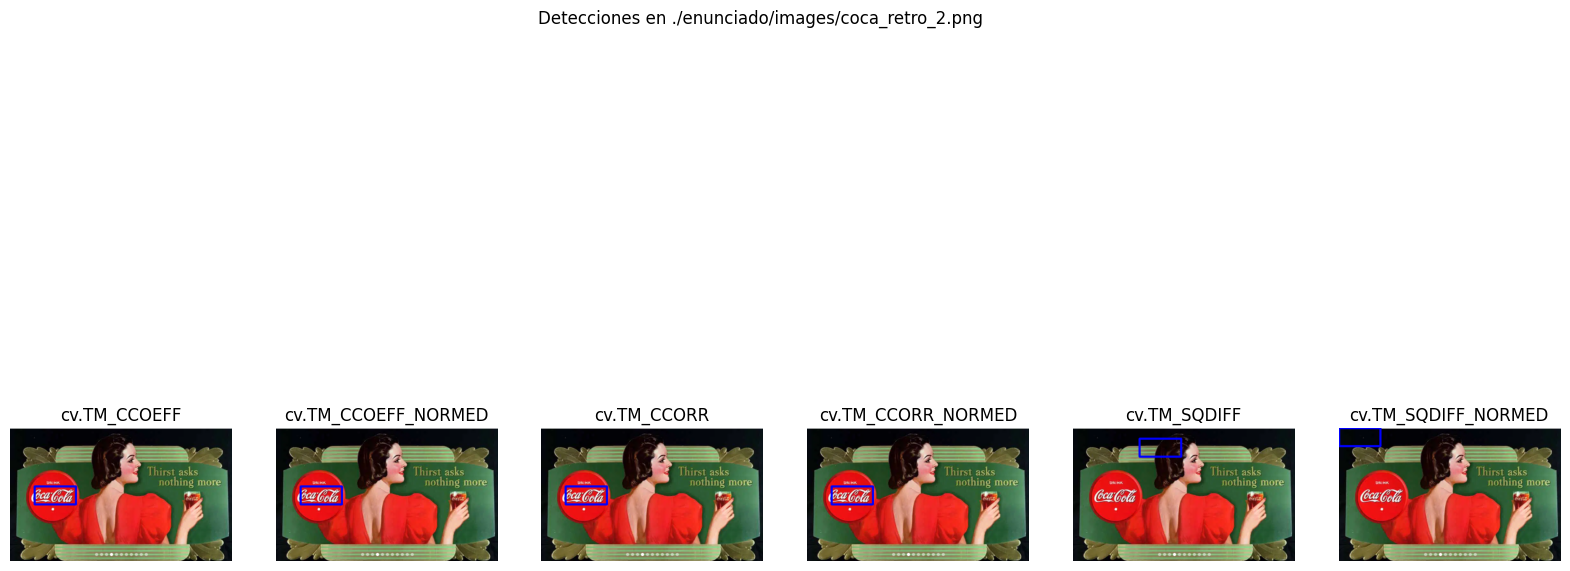

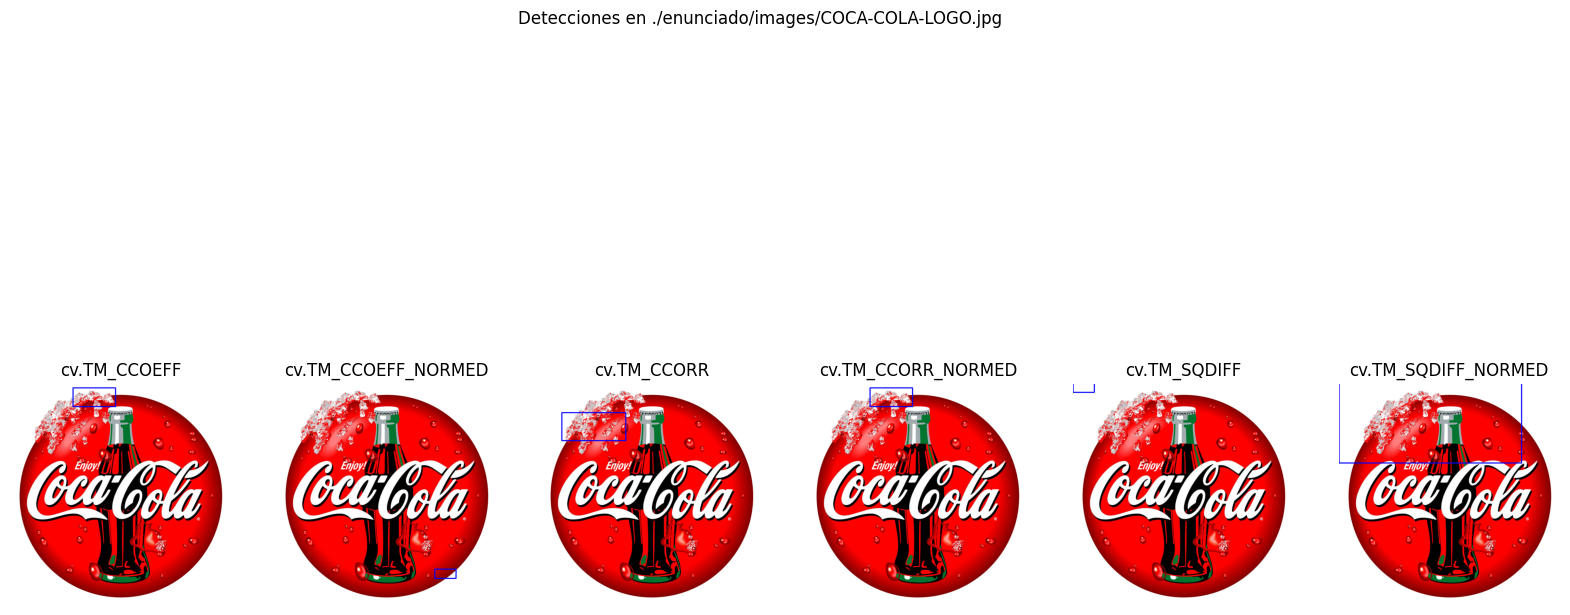

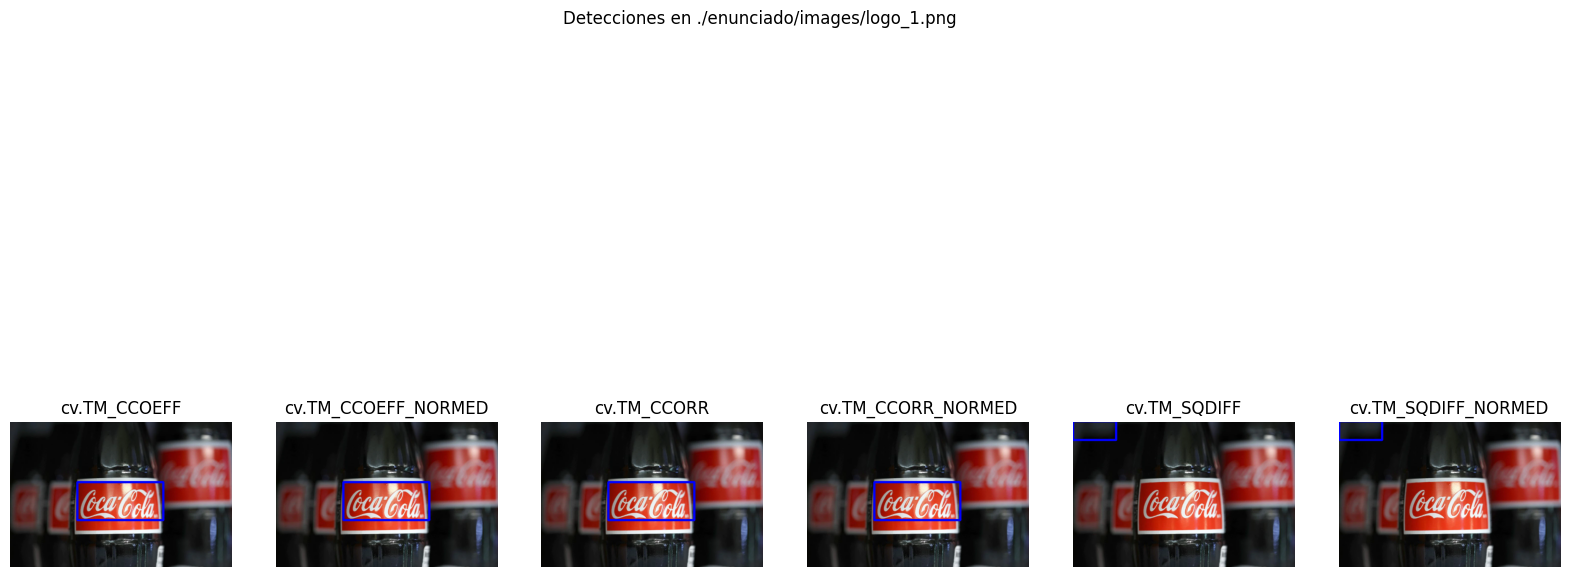

In [88]:
detect_logo_in_images(full_image_paths, template, methods, scales)


A continuacion agrego un poco mas de prints para debug, ya me voy a quedar solo con las de mayor confiaza

Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCORR/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 0.06 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


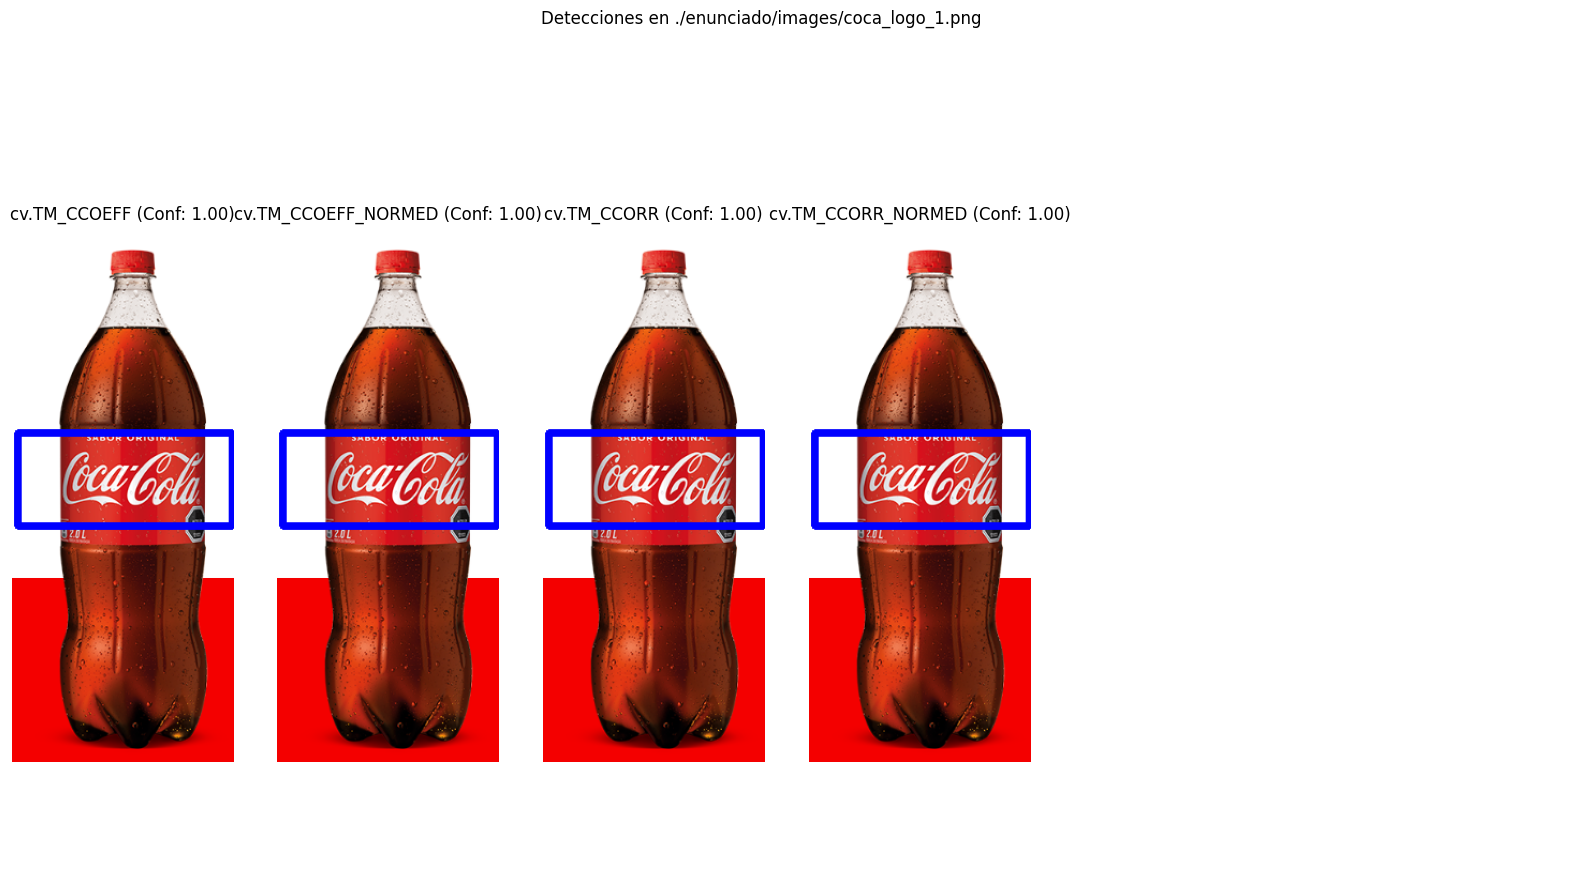

Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCOEFF/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCORR/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 0.12 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


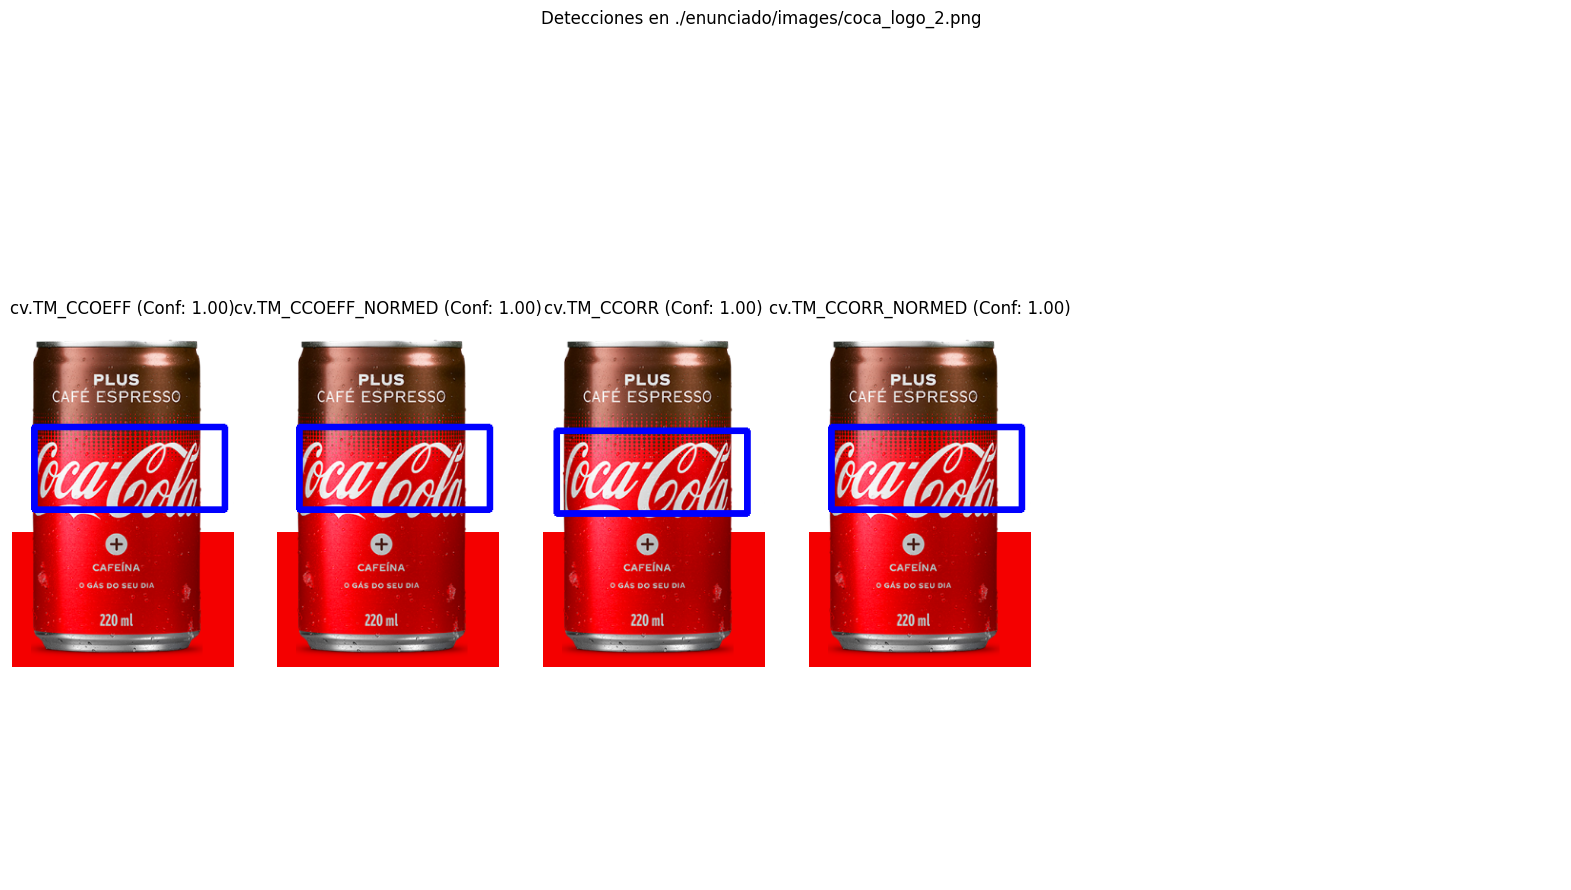

Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCORR/scale: 1
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 0.50 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


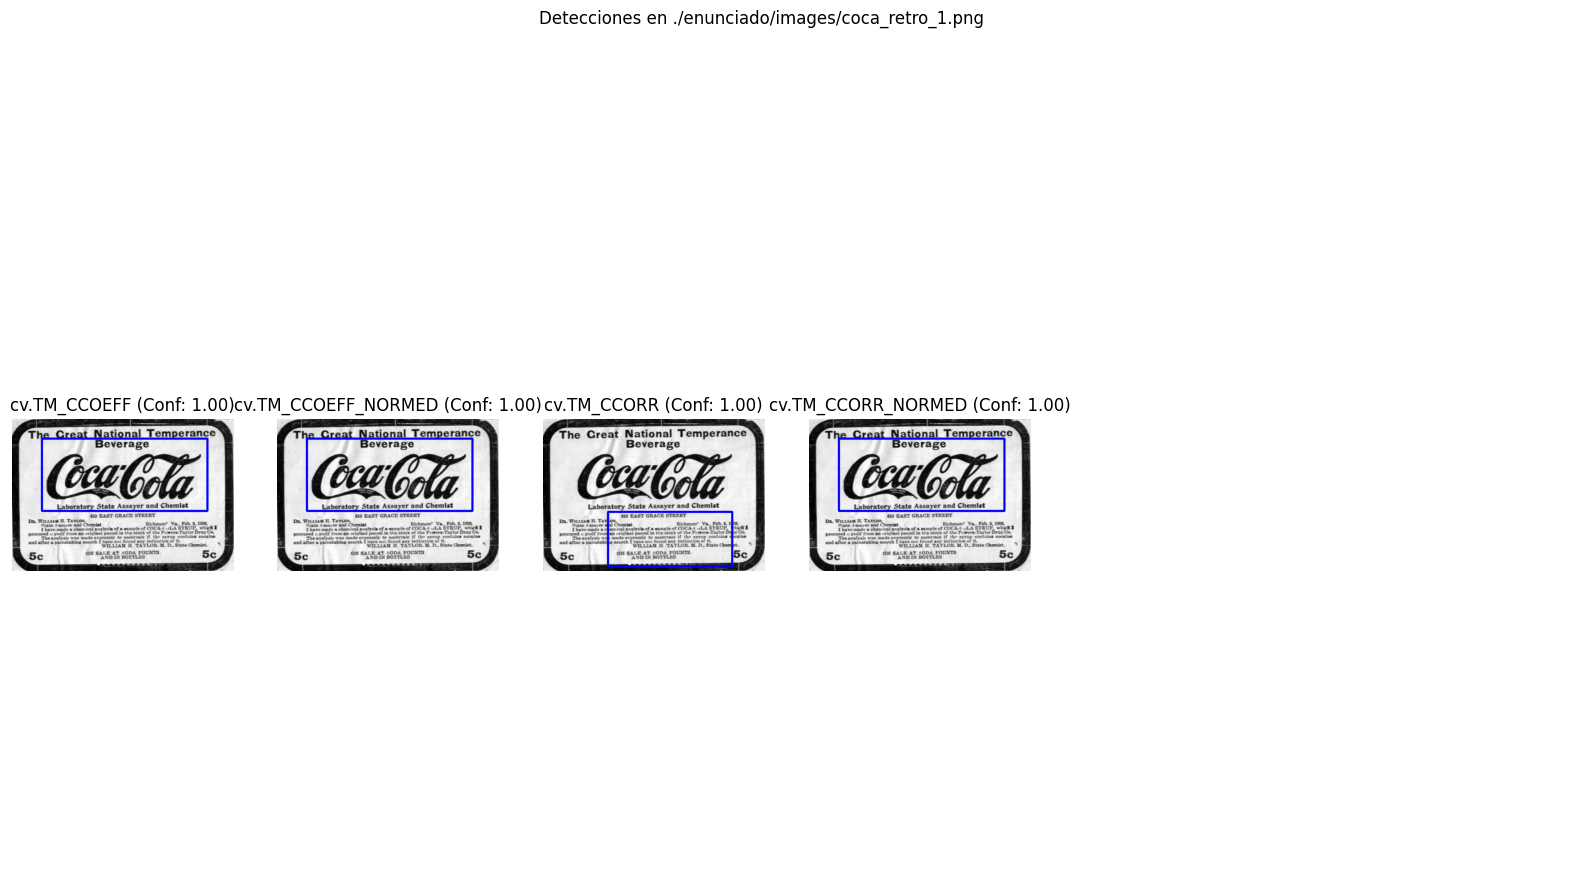

Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCOEFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCORR/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 0.37 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


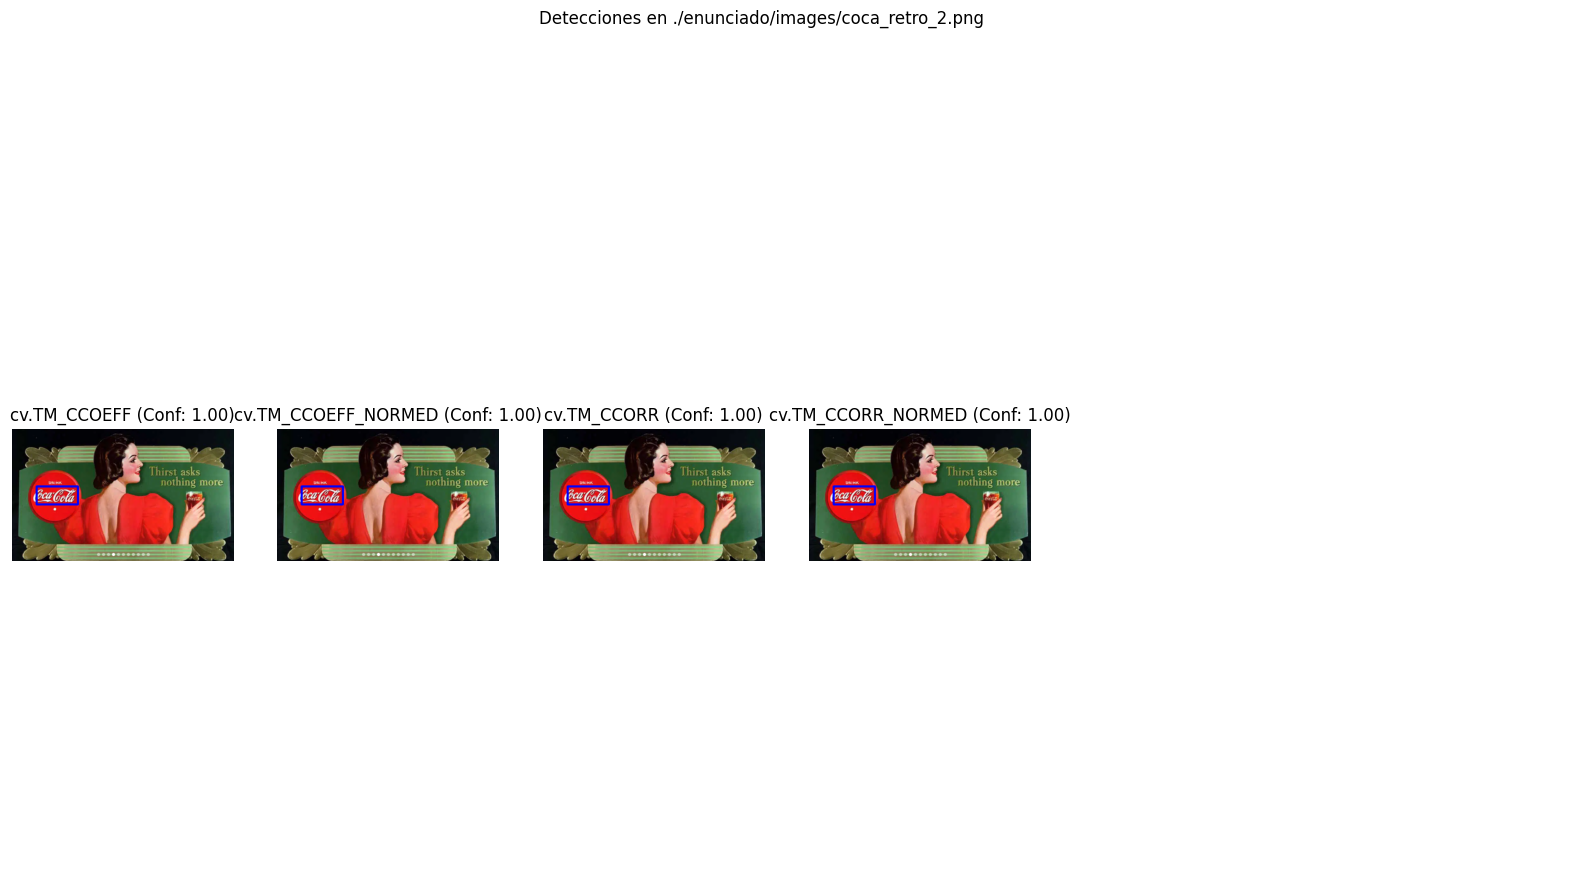

Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF/scale: 1.5
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR/scale: 1
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.39 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 0.35


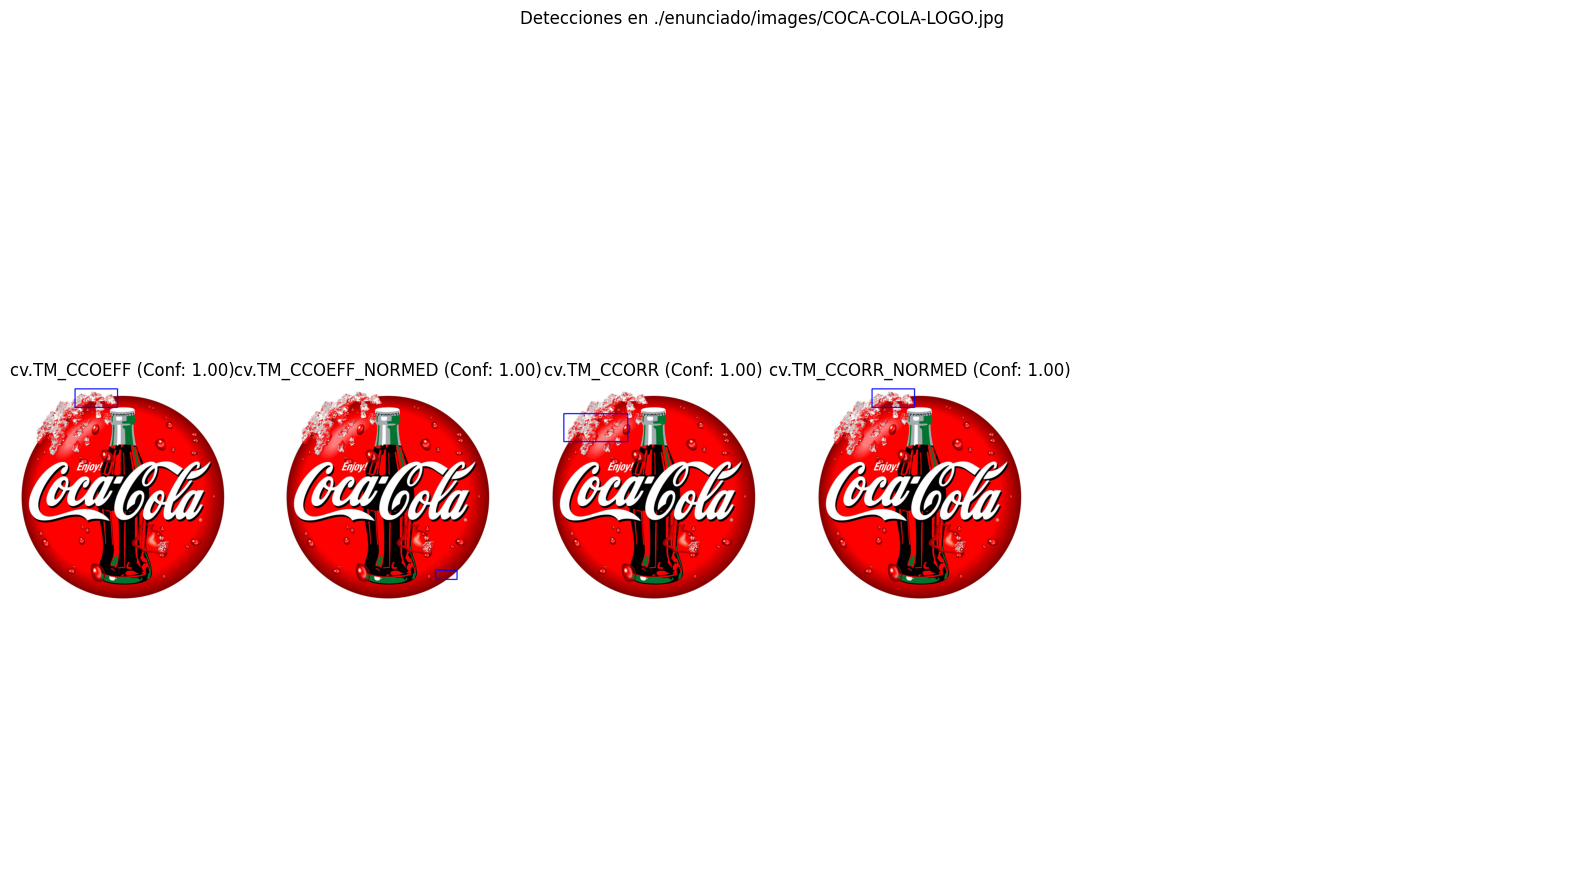

Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCORR/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 0.21 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/logo_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


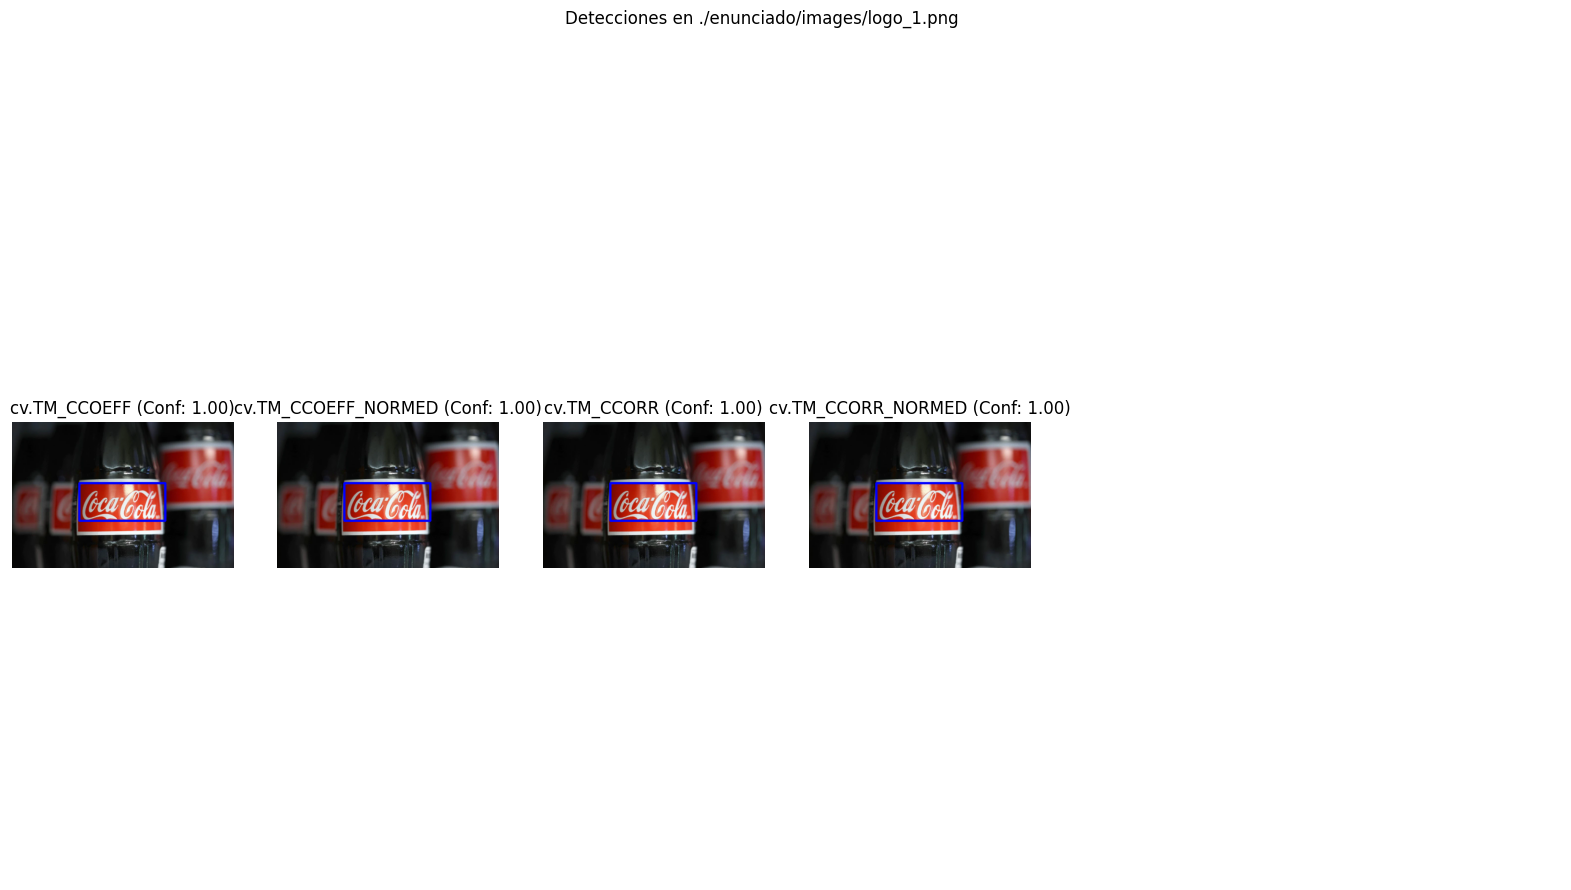

In [178]:
# Escalas a probar
scales = [0.35, 3, 2, 1.5, 1, 0.75, 0.5, 0.4, 0.25]

# Función para detectar el logo en las imágenes
def detect_logo_in_images(img_paths, template, methods, scales, threshold=0.5):
    h_template, w_template = template.shape[:2]

    for img_path in img_paths:
        img = cv.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen desde {img_path}")
            continue

        fig, axs = plt.subplots(1, 6, figsize=(20, 10))
        
        for j, meth in enumerate(methods):
            max_value = []
            max_local = []
            min_value = []
            min_local = []
            used_scales = []
            method = eval(meth)

            for scale in scales:
                img_rz = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
                h_rz, w_rz = img_rz.shape[:2]
                if h_rz < h_template or w_rz < w_template:
                    continue

                image_gray = cv.cvtColor(img_rz, cv.COLOR_BGR2GRAY)
                img_canny = cv.Canny(image_gray, 100, 200)
                
                res = cv.matchTemplate(img_canny, template, method)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    min_value.append(min_val)
                    min_local.append(min_loc)
                else:
                    max_value.append(max_val)
                    max_local.append(max_loc)
                used_scales.append(scale)

            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                id = np.argmin(min_value)
                confidence = 1 - min_value[id] / np.max(min_value)
                local = min_local[id]
            else:
                id = np.argmax(max_value)
                confidence = max_value[id] / np.max(max_value)
                local = max_local[id]

            scale_used = used_scales[id]
            x, y = int(local[0] / scale_used), int(local[1] / scale_used)
            h_rectangle, w_rectangle = int(h_template / scale_used), int(w_template / scale_used)
            bottom_right = (x + w_rectangle, y + h_rectangle)
            top_left = (x, y)
            
            img_plot = img.copy()
            cv.rectangle(img_plot, top_left, bottom_right, (255, 0, 0), 5)
            
            title = f'{meth} (Conf: {confidence:.2f})'
            print(f"Confianza de la imagen: {img_path} es: {confidence:.2f} / method: {meth}/scale: {scale_used}")
            if confidence >= threshold:
                axs[j].imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
                axs[j].set_title(title)
                axs[j].axis('off')
            else:
                axs[j].axis('off')

        plt.suptitle(f'Detecciones en {img_path}')
        plt.show()



detect_logo_in_images(full_image_paths, template, methods, scales, threshold=0.5)


scala: 2 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 2


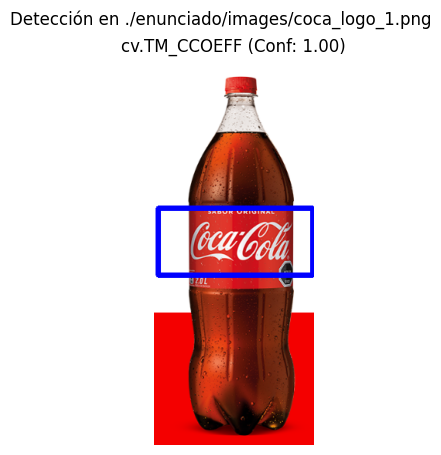

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 2 para la imagen ./enunciado/images/coca_logo_1.png
scala: 2 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 2


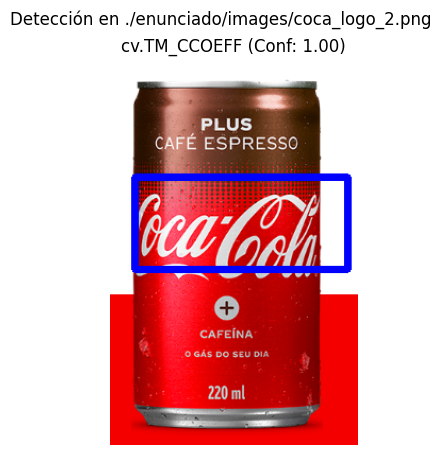

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 2 para la imagen ./enunciado/images/coca_logo_2.png
scala: 0.75 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 0.75


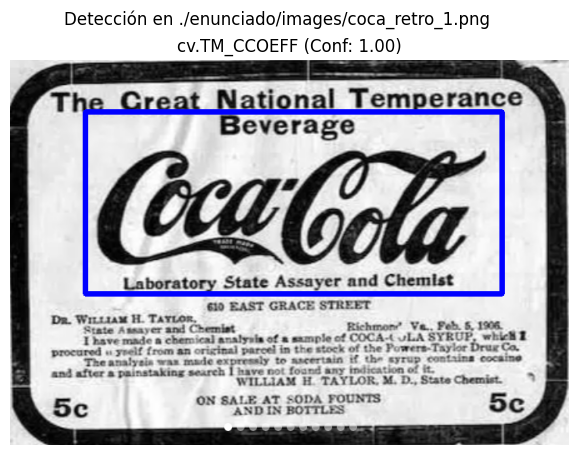

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 0.75 para la imagen ./enunciado/images/coca_retro_1.png
scala: 2 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 2


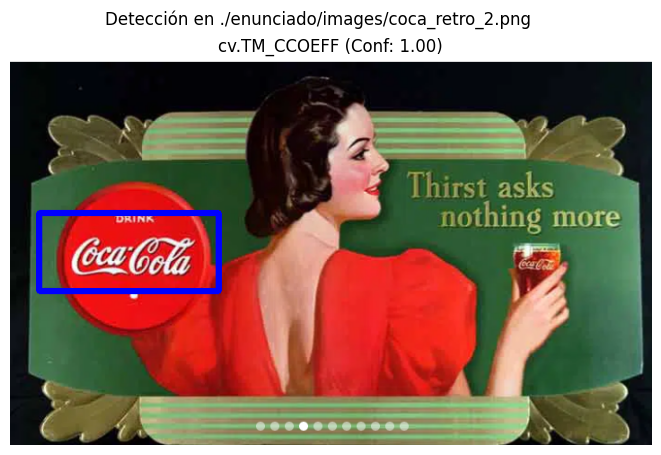

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 2 para la imagen ./enunciado/images/coca_retro_2.png
scala: 1 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 1


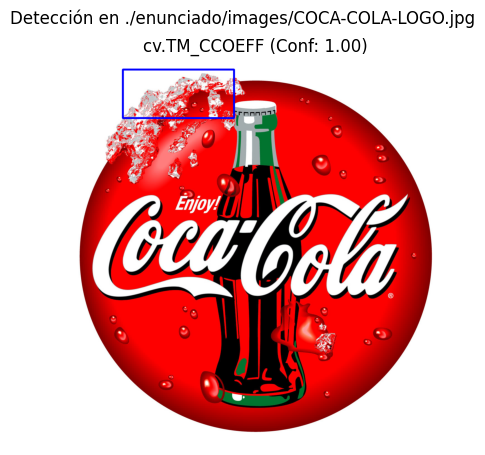

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 1 para la imagen ./enunciado/images/COCA-COLA-LOGO.jpg
scala: 1 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 1


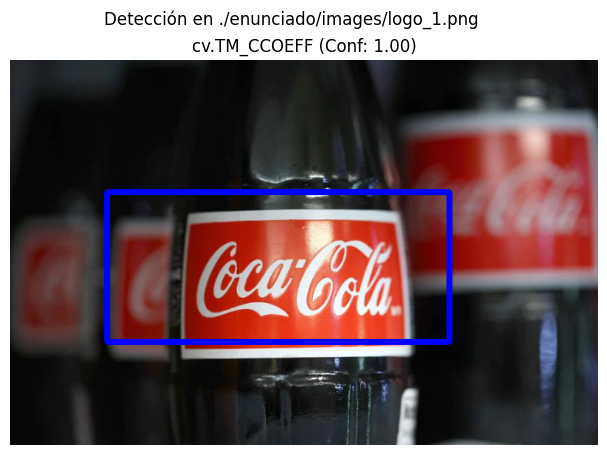

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 1 para la imagen ./enunciado/images/logo_1.png


In [207]:
# Escalas a probar
scales = [0.35, 1, 2, 0.75, 0.5, 0.4, 0.25]

# Función para detectar el logo en las imágenes
def detect_logo_in_images(img_paths, template, methods, scales, threshold=0.5):
    # dimensiones del template
    h_template, w_template = template.shape[:2]

    for img_path in img_paths:
        img = cv.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen desde {img_path}")
            continue

        best_confidence = -1
        best_bbox = None
        best_method = ""
        best_scale = 1

        # itero sobre los métodos
        for meth in methods:
            max_value = []
            max_local = []
            min_value = []
            min_local = []
            used_scales = []
            method = eval(meth) # convierto el nombre del método en una referencia de OpenCV

            # itero sobre las escalas para redimensionar la imagen
            for scale in scales:
                # redimensiono la imagen según la escala
                img_rz = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
                h_rz, w_rz = img_rz.shape[:2]

                # verifico si la imagen redimensionada es lo suficientemente grande para el template
                if h_rz < h_template or w_rz < w_template:
                    continue

                image_gray = cv.cvtColor(img_rz, cv.COLOR_BGR2GRAY)
                img_canny = cv.Canny(image_gray, 50, 150)  # Ajustar parámetros de Canny
                
                res = cv.matchTemplate(img_canny, template, method)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    min_value.append(min_val)
                    min_local.append(min_loc)
                else:
                    max_value.append(max_val)
                    max_local.append(max_loc)
                used_scales.append(scale)

            # determino la mejor detección basada en el método y la escala
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] and min_value:
                id = np.argmin(min_value)
                confidence = 1 - min_value[id] / np.max(min_value) #confianza
                local = min_local[id]
            elif max_value:
                id = np.argmax(max_value)
                confidence = max_value[id] / np.max(max_value) #confianza
                local = max_local[id]
            else:
                continue
            
            # calcular las coordenadas del bounding box para la escala utilizada
            scale_used = used_scales[id]
            x, y = int(local[0] / scale_used), int(local[1] / scale_used)
            h_rectangle, w_rectangle = int(h_template / scale_used), int(w_template / scale_used)
            bottom_right = (x + w_rectangle, y + h_rectangle)
            top_left = (x, y)
            
            print(f"scala: {scale_used} - conf: {confidence} - meth: {meth}")
            if confidence > best_confidence:
                print(f"entro! {scale_used}")
                best_confidence = confidence
                best_bbox = (top_left, bottom_right)
                best_method = meth
                best_scale = scale_used
            

            # si la mejor confianza es 1 (o muy cercana), se detiene la búsqueda
            if best_confidence >= 0.90:
                break

        # Si la mejor confianza supera el umbral, dibujamos el bounding box
        if best_confidence >= threshold:
            img_plot = img.copy()
            cv.rectangle(img_plot, best_bbox[0], best_bbox[1], (255, 0, 0), 5)
            title = f'{best_method} (Conf: {best_confidence:.2f})'
            plt.figure(figsize=(10, 5))
            plt.imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
            plt.title(title)
            plt.axis('off')
            plt.suptitle(f'Detección en {img_path}')
            plt.show()

        print(f"Mejor método: {best_method} con confianza {best_confidence:.2f} y escala {best_scale} para la imagen {img_path}")


detect_logo_in_images(full_image_paths, template, methods, scales, threshold=0.8)


No tengo forma de poder sacar la imagen de coca: ./enunciado/images/COCA-COLA-LOGO.jpg en el formato automatico. 

Pasa algo con las escalas, porque con una escala de 0,35 anda bien sin drama -> adjunto evidencia y no encuentro q estoy haciendo mal. O porque cuando obtiene la confianza despues tose la verdad ... 


de todas formas veo que el que mejor va es el de TM_CCOEFF ...


scala: 0.35 - conf: 1.0 - meth: cv.TM_CCOEFF
entro! 0.35


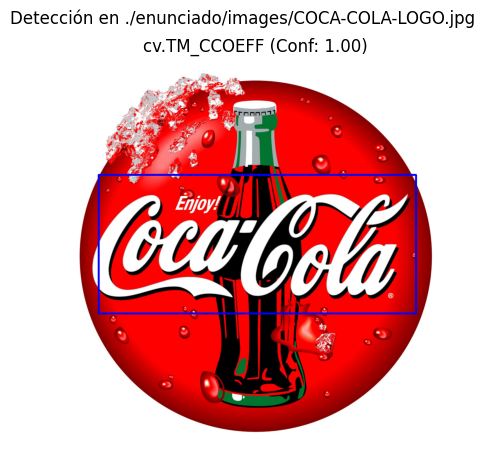

Mejor método: cv.TM_CCOEFF con confianza 1.00 y escala 0.35 para la imagen ./enunciado/images/COCA-COLA-LOGO.jpg


In [204]:
detect_logo_in_images([full_image_paths[4]], template, methods, [0.35], threshold=0.8)


## Parte 2

Plantear y validar un algoritmo para múltiples detecciones en la imagen `coco_multi.png` con el mismo template del ítem 1.

In [208]:
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def sort_points(loc, min_distance):
    #puntos cercanos
    filtered_loc = []
    for pt1 in loc:
        is_close = False
        for pt2 in filtered_loc:
            if distance(pt1, pt2) < min_distance:
                is_close = True
                break
        if not is_close:
            filtered_loc.append(pt1)
    return filtered_loc


In [246]:
def detect_logo_multi(img_path, template_path, scales, methods, threshold=0.7, min_distance=10):
    """
    Detecta múltiples instancias del logo en una imagen utilizando template matching.
    
    Args:
        img_path (str): Ruta de la imagen en la que buscar el logo.
        template_path (str): Ruta del template del logo.
        scales (list): Lista de escalas a probar.
        methods (list): Lista de métodos de template matching a probar.
        threshold (float): Umbral para la detección de coincidencias.
        min_distance (int): Distancia mínima entre puntos detectados para filtrado.
    """
    # Cargar el template y convertirlo a escala de grises
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    if template is None:
        print(f"No se pudo cargar el template desde {template_path}")
        return
    
    h_template, w_template = template.shape[:2]

    # Cargar imagen y convertirla a escala de grises
    img_multi = cv.imread(img_path)
    if img_multi is None:
        print(f"No se pudo cargar la imagen desde {img_path}")
        return
    
    img_gray = cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)
    
    # Aplicar Canny para detección de bordes
    img_canny = cv.Canny(img_gray, 100, 200)  # Ajusta estos valores según la imagen

    for method_name in methods:
        method = eval(f"cv.{method_name}")
        results = []

        for scale in scales:
            # Redimensionar imagen
            img_resized = cv.resize(img_canny, (int(img_multi.shape[1] * scale), int(img_multi.shape[0] * scale)))
            h_resized, w_resized = img_resized.shape[:2]
            
            # Verificar si la imagen redimensionada es lo suficientemente grande para el template
            if h_resized < h_template or w_resized < w_template:
                continue

            # Aplicar template matching
            res = cv.matchTemplate(img_resized, template, method)
            loc = np.where(res >= threshold)
            
            # Filtrar puntos cercanos
            filtered_loc = sort_points(zip(*loc[::-1]), min_distance * scale)
            
            # Dibujar bounding boxes en la imagen
            img_plot = img_multi.copy()
            for pt in filtered_loc:
                x, y = int(pt[0] / scale), int(pt[1] / scale)
                w_rectangle, h_rectangle = int(w_template / scale), int(h_template / scale)
                cv.rectangle(img_plot, (x, y), (x + w_rectangle, y + h_rectangle), (255, 0, 0), 2)
            
            results.append((img_plot, scale))
        
        # Mostrar los resultados para cada método y escala
        for img_plot, scale in results:
            plt.figure(figsize=(15, 15))
            plt.imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
            plt.title(f'Detección con {method_name} y escala {scale}')
            plt.axis('off')
            plt.show()

        print(f"Detección completada en {img_path} con el método {method_name}")



In [241]:
base_path+multi_image

'./enunciado/images/coca_multi.png'

In [250]:
template_path

'./enunciado/template/pattern.png'

esto de abajo no funciono ni a palos. Entro en loop el equipo. No entendi a que se refiere con el punto 3 el loco.

In [256]:
#template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)  # Cargar el template del logo
#template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
scales = [4.15, 4.20, 4.30]

methods = ["TM_CCOEFF_NORMED"]  # Métodos de template matching a probar

detect_logo_multi(base_path+multi_image, template_path, scales, methods, threshold=0.1, min_distance=10)


KeyboardInterrupt: 